<img align="left" width="30%" style="padding-right:10px;" src="../Images/Ccom.png">

___
# Computational Problem Set - Being a VGNSS Receiver

## Step 6: Creating the Initial Estimate and the Formation of Linearized Observation Equations


## Semme J. Dijkstra

<a href="https://teams.microsoft.com/l/channel/19%3afd7ef9823b064892bc126bc40f2b4710%40thread.tacv2/VGNSS?groupId=ed82d769-1aaa-4613-9de0-2dd04127f30a&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="../Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Piazza.com\"></a><br><br> 


/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jupyter-semmed/ESCI_OE_771_871
Reading SP3 file: ../mydata/igs13381.sp3
Reading SP3 file: ../mydata/igl13381.sp3
Reading rinex nav file: ../mydata/brdc2410.05n
a:      6378137.000
b:      6356752.314
f:  0.0033528106718
e2: 0.0066943800043
N:     6383561.9968
xyz = 
	      36572.327
	   -5514234.862
	    3194349.181

xyz is a 2 dimensional array with dimension lengths (3, 1)
n_gps: 29

Dxyz_gps = 
	  -14810463.942    -9214095.559    13455967.472
	   13541201.761    26996353.844   -11445216.142
	  -20837451.276    -5980879.278   -15470790.135
	    4277463.860    31010341.499     2010886.176
	   19866345.462    -2

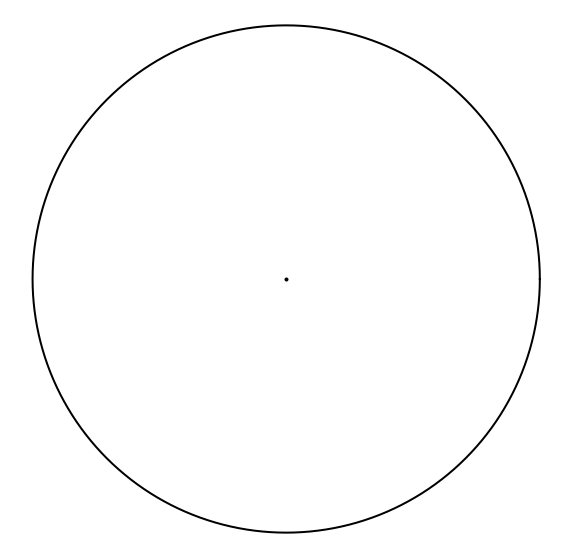

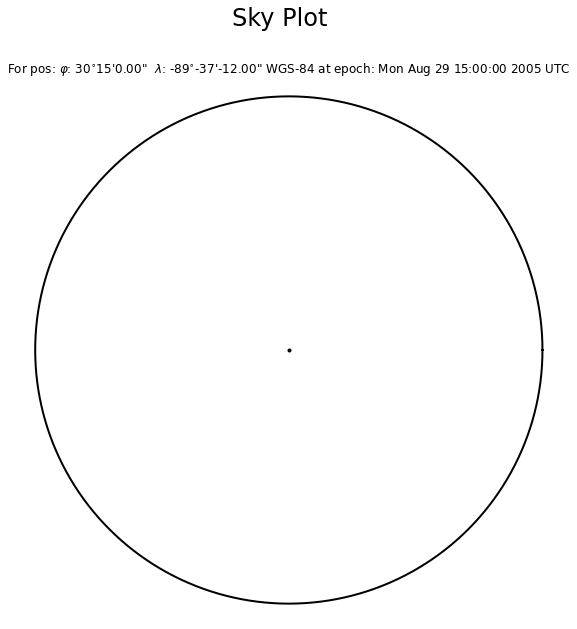

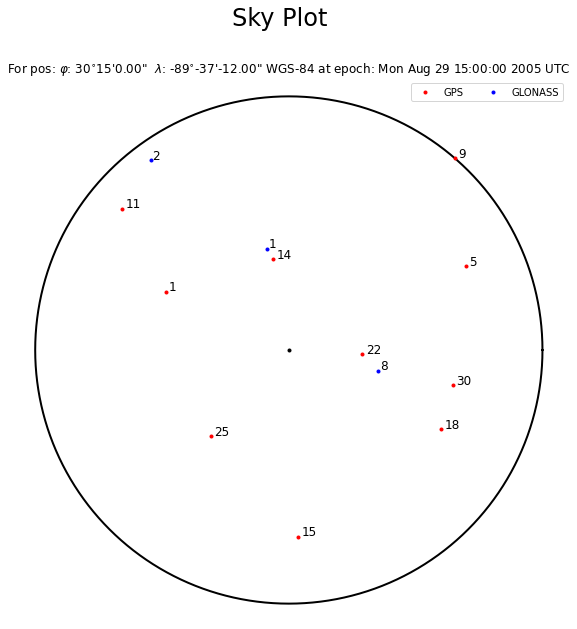

GPS PRN 2 is not visible; re-assigning bv to GPS PRN 1
Tropo delay model: 2.31/sin(sqrt(elev^2+2.50^2))
rnd_gps = 
	         -4.344
	          1.342
	          0.939
	         -0.855
	          0.843
	         -0.277
	          4.918
	         -1.051
	          6.203
	         -5.254
	         -4.948
	          3.895
	         -1.711
	          0.488
	          2.928
	          0.989
	         -0.373
	         -3.181
	          1.568
	         -3.430
	         -0.967
	          0.156
	          4.344
	          1.931
	         -0.321
	          0.073
	         -3.155
	          1.266
	          2.604

n_gps_vis = 10

error_gps = 
	  PRN    elev  Tr. Delay Rnd Noise   Clock Bias  Blunder   Tot. Uncertainty
	    1   0.728      3.468    -4.344     1000.000 2000.000           2999.123
	    5   0.359      6.522     0.843     1000.000    0.000           1007.365
	    9   0.002     52.891     6.203     1000.000    0.000           1059.094
	   11   0.219     10.436    -4.948     1000.000    0.

In [1]:
%load_ext autoreload
%autoreload 2


import sys
import os
import numpy as np

from numpy import cos,pi,sin,pi,arccos, tan, arctan, arctan2, sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
from IPython.display import HTML
vgnss_path=Path('../') # Get the path to the folder containing the mycode folder

print(vgnss_path.resolve())
sys.path.append(str(vgnss_path.resolve())) # add the folder to the list of paths 
from mycode.gnss import GNSS
from mycode.sp3 import SP3
# Start by running your previous steps - suppress the output by setting verbose to False

verbose = True
%run VGNSS_5.ipynb



from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

# from mycode.lsq import LSQ
# from mycode.ephemeris import Ephemeris

## 6.1 Form the Linearized Observation Equations

The objective of this step is to compute the linearized observation equations to be used in the least squares fix, specifically the misclosure vector $\vec w$, and design matrix $A$, as used in $\vec w+A\vec\delta-r = \vec 0$. 

___
<div class="alert alert-block alert-success">
Quick review of Parametric Non-Linear Least Squares (this is treated extensively in class):

Imagine a model $f(\vec x)$ that models an observation $\vec l$ for an unknown $\vec x$. The Taylor series allows estimation of the model value at $\vec x$ by evaluating the model for a known estimate $\hat{\vec x}$ near to $\vec x$:

$$f(\vec x) = \vec l = f(\hat{\vec x})+\dfrac{f^{(1)}(\hat{\vec x})}{1!}(\vec x - \hat{\vec x})+\dfrac{f^{(2)}(\hat{\vec x})}{2!}(\vec x - \hat{\vec x})^2+\ldots+\dfrac{f^{(n)}(\hat{\vec x})}{n!}(\vec x - \hat{\vec x})^n$$

Thus the vector $(\vec x-\hat{\vec x})$ is the correction or **adjustment** that we need to apply to get closer to $\vec x$ from $\hat{\vec x}$.

If $\hat x$ is near enough $x$; that is $\hat x - x =\vec\delta$ and $\hat{\vec \delta} \ll$ we may linearize by truncating i.e.

$$f(\vec x) = \vec l = f(\hat{\vec x})+\dfrac{f^{(1)}(\hat{\vec x})}{1!}\vec\delta\Rightarrow$$

$$f(\vec x)=f(\hat {\vec x})+A\vec\delta$$
<br><br>
Where the **design matrix** $A$ is the Jacobian of the model $f(\hat{\vec x})$ at the estimate $\hat{\vec x}$ of the unknown. The equation above may then be interpreted as the value of $\vec x$ is an estimate $\hat{\vec x}$ plus a correction $A\vec\delta$ to the estimate. The problem then becomes one of coming up with a reasonable initial estimate $f(\hat{\vec x})$ and iteratively refining it by adjusting it by the estimated correction $\hat{\vec\delta}$. In positioning this process is generally referred to as an **adjustment**. 

We make a distinction between the known **misclosures**:

$$\vec w=f(\hat{\vec x})-\vec{l^o}$$

and the unknown **residuals**

$$\vec r=f(\vec x)-\vec{l^o}=\vec{l}-\vec{l^o}$$

If we knew the value of the residuals estimation of $\vec x$ would be trivial. However, we only know the difference between the observations $\vec{l^o}$ and the modeled observations $f(\hat{\vec x})$ i.e., the misclosures. 

One way of finding our best estimate $\hat{\vec x}$ is by minimizing the sum of the squares of the residuals through the parametric method of non-linear least squares. Even when there are no redundant observations there may be several minima (several locations where LOPs approach and/or intersect)). Therefore, an initial appropriate choice of $\hat{\vec x}$ and a careful analysis of the survey design are paramount to successfully finding an estimate $\hat{\vec x}$ closest to the unknown $\vec x$. In this assignment it is unlikely that you will converge on a wrong location due to the, for geodetic applications, large redundancy and the relatively small shift in position relative to the observed distances i.e., the problem is locally nearly linear.

Our observation model is: $f(\vec x)=\vec l$ thus we may write the conditional equation $f(\vec x)-\vec l=\vec 0$ 

$$f(\vec x)-\vec l=f(\hat {\vec x})+A\vec\delta-(\vec{l^o}+r) = \vec 0$$

Thus we may write:

$$f(\hat {\vec x})-\vec{l^o}+A\vec\delta-r = \vec 0$$

or equivalently:

$$\vec w_{n,1}+A_{n,u}\vec\delta_{u,1}-r_{n,1} = \vec 0$$

Where $n$ is the number of observation, $u$ is the number of unknowns and $n-u$ is the redundancy

We will discuss in class how to minimize $\vec r^T P \vec r$, the outcome is the least squares estimator for delta:

$$\hat{\vec\delta} = -(A^TPA)^{-1}A^TP\vec w$$

with the least square estimate for the residuals:

$$\hat{\vec r}=A\hat{\vec\delta}+\vec w$$

The above means that once we converge on an appropriately small adjustment vector $\hat{\vec\delta}$ the misclosures are the best estimator of the residual vector $vec r$. As with the method of the linear least squares the variance-covariance matrix of the unknown $C_x$ is:

$$C_x=(A^T PA)^{-1}$$ 

or more commonly:

$$C_x=\hat\sigma_0^2(A^TPA)^{-1}$$

where $\hat\sigma_0^2$ the estimated variance factor given by:

$$\hat\sigma_0^2=\hat{\vec r}^TP\hat{\vec r}$$

We will discuss in class how to derive the variance-covariance matrix for the misclosure $C_w$ and residuals $C_r$:

$$C_w=\hat\sigma_0^2P^{-1}$$

$$C_r=\hat\sigma_0^2(P^{-1}+A(A^TPA)^{-1}A^T)$$

Which unsurprisingly means that the uncertainty associated to the misclosures is smaller than the uncertainty associated to the residuals
</div>

___

The first step is that we will linearize the observation equation - the observation that we expect is the length of time for a signal to traverse the baseline between the receiver and satellite vehicle $i$, plus a possible mismatch in clocks. This is a simple model, we could also include estimates for ionospheric- and tropospheric-delays and other factors here; for the sake of simplicity we will not do that in this exercise. We will want to express the solution in units of meters in an ECEF coordinate reference frame. Given that the ephemeris of the satellite are given in meters w.r.t. to WGS-84 ECEF reference frame this will be carried forward in the solution if we enter the observation equations in terms of distance [m] rather than time.

$$l_i = \sqrt{(\Delta x_i)^2+\Delta y_i)^2+\Delta z_i)^2}+c\Delta t_i$$

or, equivalently

$$l_i = \rho+c\Delta t$$

where $\rho$ was established in step 4.3, $\Delta x, \Delta y, \Delta z$ in step 4.2 and, $c$ and $\Delta t$ in Step 1.3.0. Remember that this is a simulation, in real life we do not know what the parameters are that go in the observation equations, we need to estimate them, which is what we will be doing here 

We will use the Taylor series to linearize this equation and set up your computation in such fashion that the linearization can easily be repeated as we will be finding our best estimate $\hat{\vec x}$ iteratively. This can be most easily achieved by creating a function that creates the Jacobian design matrix $A$.

We will represent the result as $A\vec\delta + \vec w = \vec0$,  where 
$A$ is the known (design) matrix of partial derivatives, $\vec\delta$ is the unknown vector of corrections to the approximate parameters and $\vec w$ is the known misclosure vector (differences between the left and right sides of the observation equation).



**How to do it:**

##### 1) What we know at the start: The pseudorange observation equations: 

$$\vec l = f(\vec x)$$ 

   or, in detail, for pseudoranges:
   
$$\vec{l}^o= \begin{pmatrix}l_1^o \\ l_2^o\\ \vdots \\ l_n^o \end{pmatrix} =
\begin{pmatrix}f_1(\vec x) \\ f_2(\vec x) \\ \vdots \\ f_n(\vec x) \end{pmatrix}=
\begin{pmatrix}\sqrt{(x_1-x_{rx})^2+(y_1-y_{rx})^2+(z_1-z_{rx})^2}+c\Delta t_1 \\ \sqrt{(x_2-x_{rx})^2+(y_2-y_{rx})^2+(z_2-z_{rx})^2}+c\Delta t_2 \\ \vdots \\ \sqrt{(x_n-x_{rx})^2+(x_n-x_{rx})^2+(x_n-x_{rx})^2}+c\Delta t_n \end{pmatrix}$$

where the:

$\vec{l}^o= \begin{pmatrix}l_1^o \\ l_2^o \\ \vdots \\ l_n^o \end{pmatrix}$ 

on the left hand side of the of the observation equations are the pseudorange measurements held in the arrays `obs_gps` and `obs_gln` created in steps 5.0.3 and 5.0.4. 

The $x_i$, $y_i$, $z_i$ are the ephemeris data and are held in the arrays `eph_gps` and `eph_gln` 

the:

$\vec x = \begin{pmatrix}x_{rx} \\ y_{rx} \\ z_{rx} \\ \Delta t \end{pmatrix}$

in the functions on the right hand side of the equations are the *unknown parameters* which we will be estimating in step 6 and for which we have the *initial approximate estimate* `xyzt_0` from step 5.0.8

$\hat{\vec x}^0 = \begin{pmatrix}x_{rx}^0 \\ y_{rx}^0 \\ z_{rx}^0 \\ \Delta t^0 \end{pmatrix}$

The fast majority of the time error is contained within the receiver clock, that is $\Delta t$ may be thought of as common to all the observations, which simplifies the equations to: 

$$\vec{l}^o= \begin{pmatrix}l_1^o \\ l_2^o\\ \vdots \\ l_n^o \end{pmatrix} =
\begin{pmatrix}f_1(\vec x) \\ f_2(\vec x) \\ \vdots \\ f_n(\vec x) \end{pmatrix}=
\begin{pmatrix}\sqrt{(x_1-x_{rx})^2+(y_1-y_{rx})^2+(z_1-z_{rx})^2}+c\Delta t \\ \sqrt{(x_2-x_{rx})^2+(y_2-y_{rx})^2+(z_2-z_{rx})^2}+c\Delta t \\ \vdots \\ \sqrt{(x_n-x_{rx})^2+(x_n-x_{rx})^2+(x_n-x_{rx})^2}+c\Delta t \end{pmatrix}$$



##### 2) A non-mathematical synopsis of the least squares procedure:
This procedure is conceptually simple.  

- 2.1) We compute what the pseudorange values would be, using the right hand side of the observation equations, assuming the approximate unknown parameter values are correct. 

- 2.2) - We compare these computed pseudorange values with the measured pseudorange values on the left hand side of the observation equations, by calculating the misclosures (computed minus measured pseudoranges). We know these misclosures will not be zero.

- 2.3) - We use the misclosure values to help find a better approximation, and return to 2.1. We (hopefully) get smaller misclosures, and use that to further improve our approximate unknown parameter values, cycling back (iterating) to 2.1 again and again.  

- 2.4) We continue iterating until the changes in the approximate unknown values, from the last iteration to the current one, is so small (say 0.1 mm) that it does not matter any more.  We then declare the process has converged, and adopt the last approximate values for our unknown parameters to be the solution.  

Bill Buckley, the conservative pundit, once described this process as *proving with exquisite precision just how wrong you were when you made your first guess.*

The critical ingredient not yet mentioned is the procedure used to get those improved estimates for the unknown parameter values.  That takes some math.


##### 3) The Taylor Series method for linearizing the observation equation:

As we saw in the quick recap the truncated Taylor Series for a function $f(\vec x)$, given an approximate estimate $\hat{\vec x}$ for the argument $x$ , is :

$$f(\vec x) = f(\hat{\vec x}) + \dfrac{\partial f}{\partial \hat{\vec x}}\biggr\rvert_{\hat{\vec x}}(\vec x - \hat{\vec x}) + R$$
		 
Where $R$ is the sum of all the remaining terms in the full Taylor Series expansion $f(x)$.  Since our purpose is to find a linear approximation for $f(x)$, we ignore $R$ and just keep the first two terms.

$$f(\vec x) = f(\hat{\vec x}) + \dfrac{\partial f}{\partial \hat{\vec x}}\biggr\rvert_{\hat{\vec x}}(\vec x - \hat{\vec x})$$
		 
Note this is in the form $f(\vec x) = b + a\Delta\vec x$ where $b = f(\hat{\vec x})$, an *intercept*, $a = \dfrac{\partial f}{\partial \hat{\vec x}}\biggr\rvert_{\hat{\vec x}}$, a gradient or slope, and $\Delta\vec x = (\vec x - \hat{\vec x})$, the unknown we will be trying to solve for. $\Delta\vec x$ is the correction to be applied to $\hat{\vec x}$  to iteratively get a better approximation:  

$ \hat{\vec x}_n = \hat{\vec x}_{n-1} + (\vec x - \hat{\vec x}_{n-1})$

In this simple example the solution is $\Delta\vec x = a^{-1}[f(\vec x) - \vec b]$.  In our real example, we will see the solution has a similar, but more complex, form.

Expanding the truncated Taylor Series to include a vector of functions, to include the measurements we make, which are modeled by the function, and to be in matrix notation, we have

$$\begin{pmatrix}l_1^o \\ l_2^o \\ \vdots \\ l_n^o \end{pmatrix} =
\begin{pmatrix}f_1(\hat{\vec x}_{rx}) \\ f_2(\hat{\vec x}_{rx}) \\ \vdots \\ f_n(\hat{\vec x}_{rx}) \end{pmatrix}+
\begin{pmatrix} \dfrac{\partial f_1}{\partial x_{rx}} & \dfrac{\partial f_1}{\partial y_{rx}} & \dfrac{\partial f_1}{\partial z_{rx}} & \dfrac{\partial f_1}{\partial \Delta t} \\ \dfrac{\partial f_2}{\partial x_{rx}} & \dfrac{\partial f_2}{\partial y_{rx}} & \dfrac{\partial f_2}{\partial z_{rx}} & \dfrac{\partial f_2}{\partial \Delta t} \\ \vdots & \vdots & \vdots & \vdots \\ \dfrac{\partial f_n}{\partial x_{rx}} & \dfrac{\partial f_n}{\partial y_{rx}} & \dfrac{\partial f_n}{\partial z_{rx}} & \dfrac{\partial f_n}{\partial \Delta t} \end{pmatrix}
\begin{pmatrix}\vec x_{rx} - \hat{\vec x}_{rx} \\ \vec y_{rx} - \hat{\vec y}_{rx} \\ \vec z_{rx} - \hat{\vec z}_{rx} \\ \vec \Delta t - \hat{\vec \Delta t}) \end{pmatrix}$$

Rearranging

$$\begin{pmatrix} \dfrac{\partial f_1}{\partial x_{rx}} & \dfrac{\partial f_1}{\partial y_{rx}} & \dfrac{\partial f_1}{\partial z_{rx}} & \dfrac{\partial f_1}{\partial \Delta t} \\ \dfrac{\partial f_2}{\partial x_{rx}} & \dfrac{\partial f_2}{\partial y_{rx}} & \dfrac{\partial f_2}{\partial z_{rx}} & \dfrac{\partial f_2}{\partial \Delta t} \\ \vdots & \vdots & \vdots & \vdots \\ \dfrac{\partial f_n}{\partial x_{rx}} & \dfrac{\partial f_n}{\delta y_{rx}} & \dfrac{\partial f_n}{\partial z_{rx}} & \dfrac{\partial f_n}{\partial \Delta t} \end{pmatrix}
\begin{pmatrix}\vec x_{rx} - \hat{\vec x}_{rx} \\ \vec y_{rx} - \hat{\vec y}_{rx} \\ \vec z_{rx} - \hat{\vec z}_{rx} \\ \vec \Delta t - \hat{\vec \Delta t}) \end{pmatrix}+
\begin{pmatrix}f_1(\hat{\vec x}_{rx}) - l_0 \\ f_2(\hat{\vec x}_{rx}) - l_1 \\ \vdots \\ f_n(\hat{\vec x}_{rx}) - l_n \end{pmatrix}
=0$$
		 
which is in the form $A\vec \delta + \vec w = \vec 0$, where:

$A=\begin{pmatrix} \dfrac{\partial f_1}{\partial x_{rx}} & \dfrac{\partial f_1}{\partial y_{rx}} & \dfrac{\partial f_1}{\partial z_{rx}} & \dfrac{\partial f_1}{\partial \Delta t} \\ \dfrac{\partial f_2}{\partial x_{rx}} & \dfrac{\partial f_2}{\partial y_{rx}} & \dfrac{\partial f_2}{\partial z_{rx}} & \dfrac{\partial f_2}{\partial \Delta t} \\ \vdots & \vdots & \vdots & \vdots \\ \dfrac{\partial f_n}{\partial x_{rx}} & \dfrac{\partial f_n}{\partial y_{rx}} & \dfrac{\partial f_n}{\partial z_{rx}} & \dfrac{\partial f_n}{\partial \Delta t} \end{pmatrix}$
the design matrix (Jacobian of Observation Model) 
          
$\vec\delta = \begin{pmatrix}\vec x_{rx} - \hat{\vec x}_{rx} \\ \vec y_{rx} - \hat{\vec y}_{rx} \\ \vec z_{rx} - \hat{\vec z}_{rx} \\ \vec \Delta t - \hat{\vec{\Delta t}}) \end{pmatrix}$ is the correction vector, also known as the unknown vector, or solution vector

$\vec w = \begin{pmatrix}f_1(\hat{\vec x}_{rx}) - l_1 \\ f_2(\hat{\vec x}_{rx}) - l_2 \\ \vdots \\ f_n(\hat{\vec x}_{rx}) - l_n \end{pmatrix}$ is the misclosure vector (computed minus observed pseudoranges)


##### 4) What we Need to Compute

The modeled observations are: 

$$\hat{ \vec l} = \begin{pmatrix}f_1(\hat{\vec x}_{rx}) \\ f_2(\hat{\vec x}_{rx}) \\ \vdots \\ f_n(\hat{\vec x}_{rx}) \end{pmatrix} = 
\begin{pmatrix}\hat l_1 \\ \hat l_2 \\ \vdots \\ \hat l_n \end{pmatrix}=
\begin{pmatrix}\sqrt{(x_1-\hat x_{rx})^2+(y_1-\hat y_{rx})^2+(z_1-\hat z_{rx})^2}+c\Delta t \\ \sqrt{(x_2-\hat x_{rx})^2+(y_2-\hat y_{rx})^2+(z_2- \hat z_{rx})^2}+c\Delta t \\ \vdots \\ \sqrt{(x_n-\hat x_{rx})^2+(y_n-\hat y_{rx})^2+(x_n-\hat z_{rx})^2}+c\Delta t\end{pmatrix}$$


The misclosure vector (computed minus measured) for the pseudoranges is computed from:

$$\vec w = \begin{pmatrix}f_1(\hat{\vec x}_{rx}) - l_1 \\ f_2(\hat{\vec x}_{rx}) - l_2 \\ \vdots \\ f_n(\hat{\vec x}_{rx}) - l_n \end{pmatrix}=
\begin{pmatrix}\hat l_1 - l_1 \\ \hat l_2 - l_2 \\ \vdots \\ \hat l_n - l_n \end{pmatrix}$$



The design matrix is the Jacobian of the observation equation i.e, it consists of an array of partial derivatives.

<div class="alert alert-block alert-success">
Quick review some rules of taking derivatives:

$$ f(x) = c\Rightarrow \dfrac{\delta f}{\delta x} = 0$$
<br><br>
$$ f(x) = ax\Rightarrow \dfrac{\delta f}{\delta x} = a$$
<br><br>
$$ f(x) = \left[ g(x)\right] ^n\Rightarrow \dfrac{\delta f}{\delta x} = n\left[g(x)\right]^{n-1}\dfrac{\delta g}{\delta x}$$

Thus: 

$f(x) = \left[ g(x)\right] ^{1/2}\rightarrow \dfrac{\partial f}{\partial x} = {1/2}\left[g(x)\right]^{-1/2}\dfrac{\partial g}{\partial x}$
<br><br>
$g(x) = \left[ h(x)\right] ^{2}\rightarrow \dfrac{\partial f}{\partial x} = {2}h(x)\dfrac{\partial g}{\partial x}$
<br><br>
$g(x) = h(x) = (c-x)\rightarrow \dfrac{\partial f}{\partial x} = -1$
</div>

Applying the rules for taking derivatives to computing an element in the first column of the design matrix, $\dfrac{\partial f_i}{\partial x_{rx}}$ we have:

$$\dfrac{\partial f_i}{\partial x_{rx}}=1/2\left[g(x)\right]^{-1/2}2h(x)(-1) = \dfrac{-(x_i-\hat{x}_{rx})}{\sqrt{(x_i-x_{rx})^2+(y_i-y_{rx})^2+(z_i-z_{rx})^2}}$$

Similarly for the second, third and fourth columns we have:

$$\dfrac{\partial f_i}{\partial y_{rx}}= \dfrac{-(y_i-\hat{y}_{rx})}{\sqrt{(x_i-x_{rx})^2+(y_i-y_{rx})^2+(z_i-z_{rx})^2}}$$
<br><br>
$$\dfrac{\partial f_i}{\partial z_{rx}}= \dfrac{-(z_i-\hat{z}_{rx})}{\sqrt{(x_i-x_{rx})^2+(y_i-y_{rx})^2+(z_i-z_{rx})^2}}$$
<br><br>
$$\dfrac{\partial f_i}{\partial t_{rx}}= c$$
<br><br>

The goal is to use the parametric method of the least squares to calculate a best estimate of our receiver location. As you have seen this is a method in which we start with an initial estimate for the receiver location that we refine 
the estimate iteratively until we stop converging, or have converged to a level deemed satisfactory. In our case we want to keep a record of the various iterations so that you may do some analysis of the results. We will keep the subsequent estimates for our location in a list `x_est`, and the associated misclosure vectors in a list `w`, and design matrices in a list `A`. (We will add another few lists for the covariance matrices and a-posteriori variance factors in step 6).

### 6.1.0 Creating the lists of Estimates  x_est of Receiver Location x

In the code cell below create the list `x_est` in such manner that the first element of the list `x_est[0]` is the initial estimate `xyzt_0` and the last element `x_est[-1]` is the current estimate (still `xyzt_0` at this point, as there is only one estimate).

In [2]:
### 6.1.0 Creating the lists x_est, w and A
x_est = [xyzt_0] # The first (and currently last) estimate of receiver location x

if verbose:
    print('    x_est = ')
    for i in range(len(x_est[-1])):
        print('%17.3f'%x_est[-1][i])

    x_est = 
        37572.327
     -5513234.862
      3195349.181
           60.000


Worked Example:

    x_est = 
        37572.327
     -5513234.862
      3195349.181
           60.000

### 6.1.1 Combining the Observations and Ephemeris

At this point we will combine the observations and ephemeris from the GPS and GLONASS satellites into arrays `l_obs` and `eph` respectively, so that we may come up with a combined solution. Note that we will weigh the observations equally. You may augment `numpy` arrays using the `np.vstack()` and `np.hstack()` functions. These functions take tuples of arrays and augment them sequentially, either vertically or horizontally e.g.,

In [3]:
array_a = np.array([[1,4],[2,5]])
array_b = np.array([[3,6]]).T
array_c = np.hstack((array_a,array_b))
print('array_a: \n' + str(array_a))
print('\narray_b: \n' + str(array_b))
print('\n[array_a|array_b]:\n ' + str(array_c))

array_a: 
[[1 4]
 [2 5]]

array_b: 
[[3]
 [6]]

[array_a|array_b]:
 [[1 4 3]
 [2 5 6]]


Determine the total number of visible satellites (sum of `n_gps_vis` and `n_gln_vis`) and assign this to the variable `n_svs`. Also create the array `l_obs`. This array should have as its first column the number 1 to identify GPS constellation svs, and the number 2 to identify GLONASS svs. The second column should contain the PRN number of each satellite within its constellation, and the third column the observed pseudorange. 

In [4]:
### 6.1.1 Combining the Observations and Ephemeris

# The total number of satellite vehicles
n_svs = n_gps_vis+n_gln_vis

# Augment a vector of ones (GPS) with the GPS PRNs and Pseudoranges (note the use of the hstack() function)
l_obs = np.hstack((np.ones((n_gps_vis,1)),obs_gps))

# Augment l_obs with GLONASS data (note the use of both the hstack and vstack() functions)
l_obs = np.vstack((l_obs,np.hstack((2*np.ones((n_gln_vis,1)),obs_gln))))

# Similary create the array eph holding the constellation identifier, PRN and ephemeri
eph = np.hstack((np.ones((n_gps_vis,1)), eph_gps[visible_gps,:]))
eph = np.vstack((eph,np.hstack((2*np.ones((n_gln_vis,1)),eph_gln[visible_gln,:]))))

if verbose:
    print('n_svs = %d'%n_svs)
    
    print('\nl_obs = ')
    for pr in l_obs:
        print( '%7d %3d %15.3f'%(pr[0],pr[1],pr[2]))    
    
    print('\neph = ')
    for sv in eph:
        print( '%7d %3d %15.3f %15.3f %15.3f'%(sv[0],sv[1],sv[2],sv[3],sv[4]))

n_svs = 13

l_obs = 
      1   1    22032807.560
      1   5    23474543.431
      1   9    25444690.813
      1  11    24469065.572
      1  14    21031481.924
      1  15    23243893.168
      1  18    22712827.260
      1  22    20762931.452
      1  25    21418253.357
      1  30    22628289.586
      2   1    20101961.485
      2   2    23878066.670
      2   8    19892959.985

eph = 
      1   1   -14773891.615   -14728330.421    16650316.653
      1   5    19902917.789    -7766747.541    15493186.526
      1   9    16624200.428     4239222.358    19840641.900
      1  11   -18224113.868    -2457225.422    19190848.713
      1  14    -1849009.819   -15167640.371    21782987.338
      1  15     1257336.334   -24255283.298   -10499249.025
      1  18    17763443.373   -19514551.381      832990.033
      1  22     9289688.496   -21821707.258    12110851.768
      1  25    -9321189.326   -24756368.838     2261075.009
      1  30    19177152.754   -17369709.889     5448204.587
      2

Worked Example:

    n_svs = 13

    l_obs = 
      1   1    22032813.633
      1   5    23474541.526
      1   9    25444682.772
      1  11    24469069.082
      1  14    21031486.016
      1  15    23243891.073
      1  18    22712828.074
      1  22    20762936.197
      1  25    21418246.029
      1  30    22628290.792
      2   1    20101960.993
      2   2    23878065.140
      2   8    19892960.260

    eph = 
      1   1   -14773891.615   -14728330.421    16650316.653
      1   5    19902917.789    -7766747.541    15493186.526
      1   9    16624200.428     4239222.358    19840641.900
      1  11   -18224113.868    -2457225.422    19190848.713
      1  14    -1849009.819   -15167640.371    21782987.338
      1  15     1257336.334   -24255283.298   -10499249.025
      1  18    17763443.373   -19514551.381      832990.033
      1  22     9289688.496   -21821707.258    12110851.768
      1  25    -9321189.326   -24756368.838     2261075.009
      1  30    19177152.754   -17369709.889     5448204.587
      2   1    -2412174.364   -13498394.991    21478365.609
      2   2   -13976942.409     1636747.273    21155365.107
      2   8    10565458.545   -21155975.581     9532202.091

### 6.1.2 Determining the Misclosures and Design Matrix

In this step we will calculate the misclosure vector and design matrix associated to the current estimate  and add it to the lists `w` and `A` respectively 

In the code cell below we create a function called `get_design_misclosure_range()` which for now only allocate memory for the misclosure vector `w` and design matrix `A` by creating a `n_svs` x 1 column vector and a `n_svs` x 4 matrix.

Note that the addition of the result to the lists is a little clunky here. We may do this in a much more elegant and efficient manner. However, that would make the code less easily read and take the focus away from understanding the method of the least squares.


In [5]:
# x_est
# eph[-1,2]
# # eph[:,2:3]
# sqrt((eph[:,2:3]-x_est[0][0])**2+(eph[:,3:4]-x_est[0][1])**2+(eph[:,4:5]-x_est[0][2])**2) 
# # x_est[0]
# l_obs
# # c

In [6]:
### 6.1.2 Determining the Misclosures and Design Matrix

def get_design_misclosure_range(x_est, eph, l_obs, c, verbose):
    
    # 6.1.2 Allocate memory for the misclosure vector w and design matrix A
    n_svs = eph.shape[0]
    
    w = np.zeros((n_svs,1))
    A = np.zeros((n_svs,4))
    
#     ### 6.1.3 Create the model ranges rho_mod and observations l_mod
    
    rho_mod = sqrt((eph[:,2:3]-x_est[0])**2+(eph[:,3:4]-x_est[1])**2+(eph[:,4:5]-x_est[2])**2)   
    l_mod = rho_mod + c*x_est[3]  
    
#     ### 6.1.4 Using the model observation and the pseudoranges determine the misclosures
    
    w = l_mod - l_obs[:,2:3]
    
#     ### 6.1.5 Using the model Observations determine design natrix A

    A[:,0:1] = -(eph[:,2:3]-x_est[0])/rho_mod
    A[:,1:2] = -(eph[:,3:4]-x_est[1])/rho_mod
    A[:,2:3] = -(eph[:,4:5]-x_est[2])/rho_mod
    A[:,3:4] = c
    
    if verbose:
        print('    l_mod = ')
        for l in l_mod:
            print('%19.3f'%l)
        print('\n    rho_mod = ')
        for rho in rho_mod:
            print('%19.3f'%rho)
        
    return w, A

result = [[0],[0]]

### Determining the Misclosures and Design Matrix
# Determine the misclosure and design matrix for the current estimate x_est
w, A = get_design_misclosure_range(x_est[0],eph,l_obs, c, True)


print('\nThe initial misclosure vector w =')
for i in range(n_svs):
    print('%9.3f'%(w[i]))
print('\nThe initial design matrix A =')
for i in range(n_svs):
    print('%9.3f %7.3f %7.3f %7.3f'%(A[i,0],A[i,1],A[i,2],A[i,3]))


    l_mod = 
    18009577768.240
    18011019741.780
    18012989422.208
    18012015507.744
    18008577625.748
    18010791709.904
    18010259241.476
    18008309322.690
    18008966104.912
    18010174342.276
    18007648045.436
    18011424059.317
    18007439373.581

    rho_mod = 
       22030288.240
       23472261.780
       25441942.208
       24468027.744
       21030145.748
       23244229.904
       22711761.476
       20761842.690
       21418624.912
       22626862.276
       20100565.436
       23876579.317
       19891893.581

The initial misclosure vector w =
17987544960.680
17987545198.350
17987544731.395
17987546442.171
17987546143.824
17987547816.737
17987546414.216
17987546391.239
17987547851.554
17987546052.691
17987546083.951
17987545992.647
17987546413.596

The initial design matrix A =
    0.672   0.418  -0.611 299792458.000
   -0.846   0.096  -0.524 299792458.000
   -0.652  -0.383  -0.654 299792458.000
    0.746  -0.125  -0.654 299792458.000
    0.090   0.459

Worked Example:

    The initial misclosure vector w =
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000
    0.000

    The initial design matrix A =
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000
    0.000   0.000   0.000   0.000

### 6.1.3 Determine the Model Observations  $\hat{ \vec l}$

In the code cell for step 6.1.2 update the function call to `get_design_misclosure_range()` to print the results (`verbose` is `True`). Note update the call to the function ***NOT*** The function itself!!

Also in the function update the segment 6.1.3 to calculate the *model distance* from the receiver to the satellites i.e., from our current best estimate of the position to the satellite. Use the equations for $\hat{ \vec l}$ from section *5.1 4) What we Need to Compute* for this purpose.

In [ ]:
# 6.1.3 Determine the Model Observations
### Determining the Misclosures and Design Matrix

# Start by creating the empty lists w and A
w = []
A = []

# Determine the misclosure and design matrix for the current estimate x_est
result = get_design_misclosure_range(x_est[0],eph,l_obs, c, True)

# append the results to the lists w and A (this could be done more efficiently, kept it easy to understand here)
w.append(result[0])
A.append(result[1])

if verbose:
    print('\nThe initial misclosure vector w =')
    for i in range(n_svs):
        print('%9.3f'%(w[-1][i]))
    print('\nThe initial design matrix A =')
    for i in range(n_svs):
        print('%9.3f %7.3f %7.3f %7.3f'%(A[-1][i,0],A[-1][i,1],A[-1][i,2],A[-1][i,3]))

Worked Example:

    l_mod = 
       22030288.240
       23472261.780
       25441942.208
       24468027.744
       21030145.748
       23244229.904
       22711761.476
       20761842.690
       21418624.912
       22626862.276
       20100565.436
       23876579.317
       19891893.581

    rho_mod = 
       22030288.240
       23472261.780
       25441942.208
       24468027.744
       21030145.748
       23244229.904
       22711761.476
       20761842.690
       21418624.912
       22626862.276
       20100565.436
       23876579.317
       19891893.581

### 6.1.4 Determine the Misclosures $w$

In the `get_design_misclosure_range()` update the segment 6.1.4 to calculate the misclosures using the equations from *6.1 4) What we Need to Compute* for $w$

In [7]:
# 6.1.4 Determine the Misclosures
### Determining the Misclosures and Design Matrix

# Start by creating the empty lists w and A
w = []
A = []

# Determine the misclosure and design matrix for the current estimate x_est
result = get_design_misclosure_range(x_est[0],eph,l_obs, c, True)

# append the results to the lists w and A (this could be done more efficiently, kept it easy to understand here)
w.append(result[0])
A.append(result[1])

if verbose:
    print('\nThe initial misclosure vector w =')
    for i in range(n_svs):
        print('%9.3f'%(w[-1][i]))
    print('\nThe initial design matrix A =')
    for i in range(n_svs):
        print('%9.3f %7.3f %7.3f %7.3f'%(A[-1][i,0],A[-1][i,1],A[-1][i,2],A[-1][i,3]))

    l_mod = 
    18009577768.240
    18011019741.780
    18012989422.208
    18012015507.744
    18008577625.748
    18010791709.904
    18010259241.476
    18008309322.690
    18008966104.912
    18010174342.276
    18007648045.436
    18011424059.317
    18007439373.581

    rho_mod = 
       22030288.240
       23472261.780
       25441942.208
       24468027.744
       21030145.748
       23244229.904
       22711761.476
       20761842.690
       21418624.912
       22626862.276
       20100565.436
       23876579.317
       19891893.581

The initial misclosure vector w =
17987544960.680
17987545198.350
17987544731.395
17987546442.171
17987546143.824
17987547816.737
17987546414.216
17987546391.239
17987547851.554
17987546052.691
17987546083.951
17987545992.647
17987546413.596

The initial design matrix A =
    0.672   0.418  -0.611 299792458.000
   -0.846   0.096  -0.524 299792458.000
   -0.652  -0.383  -0.654 299792458.000
    0.746  -0.125  -0.654 299792458.000
    0.090   0.459

    The initial misclosure vector w =
    -2525.393
    -2279.746
    -2740.565
    -1041.338
    -1340.268
      338.831
    -1066.597
    -1093.507
      378.883
    -1428.515
    -1395.556
    -1485.823
    -1066.679

### 6.1.5 Determine The Design Matrix $A$

In the `get_design_misclosure_range()` update the segment ### 6.1.4 to calculate the misclosures using the equations from *6.1 4) What we Need to Compute* for the columns of $A$.

In [ ]:
# 6.1.5 Determine The Design Matrix
### Determining the Misclosures and Design Matrix

# Start by creating the empty lists w and A
w = []
A = []

# Determine the misclosure and design matrix for the current estimate x_est
result = get_design_misclosure_range(x_est[0],eph,l_obs, c, True)

# append the results to the lists w and A (this could be done more efficiently, kept it easy to understand here)
w.append(result[0])
A.append(result[1])

if verbose:
    print('\nThe initial misclosure vector w =')
    for i in range(n_svs):
        print('%9.3f'%(w[-1][i]))
    print('\nThe initial design matrix A =')
    for i in range(n_svs):
        print('%9.3f %7.3f %7.3f %7.3f'%(A[-1][i,0],A[-1][i,1],A[-1][i,2],A[-1][i,3]))


    The initial design matrix A =
    0.672   0.418  -0.611 299792458.000
    -0.846   0.096  -0.524 299792458.000
    -0.652  -0.383  -0.654 299792458.000
     0.746  -0.125  -0.654 299792458.000
     0.090   0.459  -0.884 299792458.000
    -0.052   0.806   0.589 299792458.000
    -0.780   0.616   0.104 299792458.000
    -0.446   0.786  -0.429 299792458.000
     0.437   0.898   0.044 299792458.000
    -0.846   0.524  -0.100 299792458.000
     0.122   0.397  -0.910 299792458.000
     0.587  -0.299  -0.752 299792458.000
    -0.529   0.786  -0.319 299792458.000